# Hypothesis 1

There is a relation between EEG signal and 3 levels of stress.

For each pair of person and task, there are 3 distinct groups of EEG signals representing the 3 levels of stress.

In [1]:
import pandas as pd
pandasRaw = pd.read_csv("data/nuttasit_mathstress_2021-08-12-08.09.53.csv")
# pandasRaw = pd.read_csv("data/nuttasit_mathcontrol_2021-08-12-07.51.14.csv")


def marker_converter(pandasRaw):
    marker_idx = list(pandasRaw['Marker'].unique())
    # print(marker_idx)
    new_marker = []
    for data in pandasRaw['Marker']:
        if(data == '0' or data == 0):
            i = 0
        else:
            i = marker_idx.index(data)
        new_marker.append(i)
    set(new_marker)
    pandasRaw['Marker'] = new_marker
    pandasRaw = pandasRaw.drop(columns='timestamps')
    return pandasRaw,marker_idx

pandasRaw,marker_idx = marker_converter(pandasRaw)
pandasRaw

/home/akrarads/venv/hci/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Fp1,Fp2,F3,F4,F7,F8,O1,O2,Marker
0,-15380.414,10622.711,8979.701,11114.428,-960.231,12954.177,-2743.721,-5477.429,0
1,-15404.018,10604.338,8962.625,11094.087,-979.141,12931.445,-2757.959,-5487.845,0
2,-15413.920,10594.683,8951.717,11081.414,-986.830,12919.264,-2769.873,-5501.927,0
3,-15393.915,10612.676,8960.792,11095.160,-975.676,12937.637,-2763.726,-5495.958,0
4,-15376.212,10623.158,8976.416,11111.410,-959.873,12955.854,-2746.359,-5478.323,0
...,...,...,...,...,...,...,...,...,...
216079,-10235.848,10159.494,8221.978,10392.958,511.698,12259.775,-1590.908,-5159.699,0
216080,-10236.786,10159.852,8221.485,10391.080,511.184,12256.154,-1590.528,-5164.460,0
216081,-10259.093,10141.143,8201.883,10367.946,491.135,12234.250,-1616.992,-5188.198,0
216082,-10268.279,10131.621,8192.630,10359.608,481.255,12227.142,-1629.263,-5197.607,0


In [2]:
for marker in pandasRaw['Marker'].unique():
    print(marker, marker_idx[marker])

0 0
1 math,LowStress,start
2 math,LowStress,S
3 math,LowStress,T
4 fixation,None,None
5 math,LowStress,F
6 math,MildStress,start
7 math,MildStress,T
8 math,MildStress,S
9 math,MildStress,F
10 math,HigherStress,start
11 math,HigherStress,S
12 math,HigherStress,T
13 math,HigherStress,F


In [3]:
import mne
def pandasObject_to_mneRaw(pandasObject, sfreq):
    ch_names = list(pandasObject.columns)
    ch_types = ['eeg'] * (len(pandasObject.columns) - 1) + ['stim']
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    pandasObject = pandasObject.T  #mne looks at the tranpose() format
    pandasObject[:-1] *= 1e-6  #convert from uVolts to Volts (mne assumes Volts data)

    info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, verbose=False)

    raw = mne.io.RawArray(pandasObject, info,verbose=False)
    raw.set_montage(ten_twenty_montage)
    # raw.plot()
    return raw

In [4]:
raw = pandasObject_to_mneRaw(pandasRaw, sfreq=250)

In [5]:
# Preprocess
raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
raw.filter(1, None, verbose=False) # Slow drift
pass
# ica = mne.preprocessing.ICA(n_components=8, max_iter='auto')
# ica.fit(raw, verbose=False)
# raw = ica.apply(raw, verbose=False)

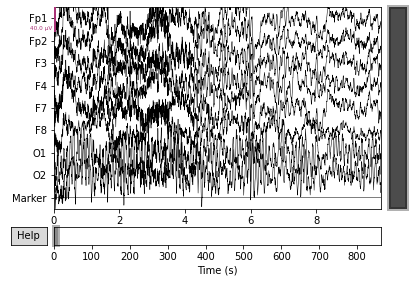

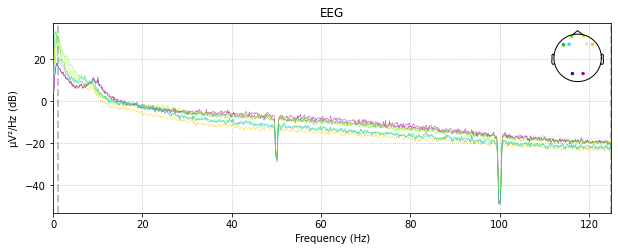

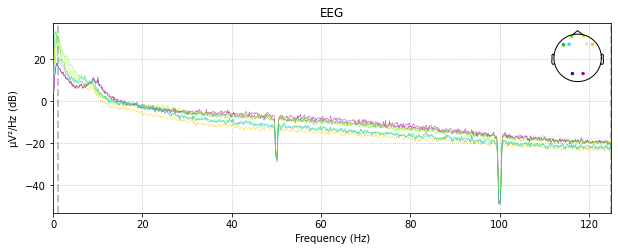

In [6]:
raw.plot()
raw.plot_psd()

In [7]:
import numpy as np
print(marker_idx)
events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False, uint_cast=False)
events = np.delete(events, np.argwhere(events[:,2] == marker_idx.index('math,LowStress,S')), axis=0) # break
events = np.delete(events, np.argwhere(events[:,2] == marker_idx.index('math,LowStress,T')), axis=0) # break
events = np.delete(events, np.argwhere(events[:,2] == marker_idx.index('math,LowStress,F')), axis=0) # break
events = np.delete(events, np.argwhere(events[:,2] == marker_idx.index('math,MildStress,S')), axis=0) # break
events = np.delete(events, np.argwhere(events[:,2] == marker_idx.index('math,MildStress,T')), axis=0) # break
events = np.delete(events, np.argwhere(events[:,2] == marker_idx.index('math,MildStress,F')), axis=0) # break
events = np.delete(events, np.argwhere(events[:,2] == marker_idx.index('math,HigherStress,S')), axis=0) # break
events = np.delete(events, np.argwhere(events[:,2] == marker_idx.index('math,HigherStress,T')), axis=0) # break
events = np.delete(events, np.argwhere(events[:,2] == marker_idx.index('math,HigherStress,F')), axis=0) # break
events
# epochs = mne.Epochs(raw, events, tmin=t_start, tmax=t_stop, baseline=(t_start,t_stop), verbose=False)

['0', 'math,LowStress,start', 'math,LowStress,S', 'math,LowStress,T', 'fixation,None,None', 'math,LowStress,F', 'math,MildStress,start', 'math,MildStress,T', 'math,MildStress,S', 'math,MildStress,F', 'math,HigherStress,start', 'math,HigherStress,S', 'math,HigherStress,T', 'math,HigherStress,F', 0]


array([[  6251,      0,      1],
       [  6868,      0,      1],
       [  7349,      0,      1],
       [  7966,      0,      1],
       [  8356,      0,      1],
       [  8716,      0,      1],
       [  9062,      0,      1],
       [  9664,      0,      1],
       [ 10280,      0,      1],
       [ 10896,      0,      1],
       [ 11512,      0,      1],
       [ 12099,      0,      1],
       [ 12595,      0,      1],
       [ 13045,      0,      1],
       [ 13661,      0,      1],
       [ 14128,      0,      1],
       [ 14744,      0,      1],
       [ 15346,      0,      1],
       [ 15962,      0,      1],
       [ 16472,      0,      4],
       [ 19237,      0,      1],
       [ 19854,      0,      1],
       [ 20335,      0,      1],
       [ 20937,      0,      1],
       [ 21553,      0,      1],
       [ 22139,      0,      1],
       [ 22590,      0,      1],
       [ 22936,      0,      1],
       [ 23267,      0,      1],
       [ 23763,      0,      1],
       [ 2

In [8]:
events
interested_events = []
prev_is_Low_start = False
prev_is_Mil_start = False
prev_is_Hig_start = False
Low_start = marker_idx.index('math,LowStress,start')
Mil_start = marker_idx.index('math,MildStress,start')
Hig_start = marker_idx.index('math,HigherStress,start')

for event in events:
    if(event[2] == Low_start and prev_is_Low_start == False):
        interested_events.append(list(event))
        prev_is_Low_start = True
    elif(event[2] != Low_start):
        prev_is_Low_start = False

    if(event[2] == Mil_start and prev_is_Mil_start == False):
        interested_events.append(list(event))
        prev_is_Mil_start = True
    elif(event[2] != Mil_start):
        prev_is_Mil_start = False

    if(event[2] == Hig_start and prev_is_Hig_start == False):
        interested_events.append(list(event))
        prev_is_Hig_start = True
    elif(event[2] != Hig_start):
        prev_is_Hig_start = False


    if(event[2] == 4):
        interested_events.append(list(event))
    print(event)
interested_events = np.array(interested_events)

[6251    0    1]
[6868    0    1]
[7349    0    1]
[7966    0    1]
[8356    0    1]
[8716    0    1]
[9062    0    1]
[9664    0    1]
[10280     0     1]
[10896     0     1]
[11512     0     1]
[12099     0     1]
[12595     0     1]
[13045     0     1]
[13661     0     1]
[14128     0     1]
[14744     0     1]
[15346     0     1]
[15962     0     1]
[16472     0     4]
[19237     0     1]
[19854     0     1]
[20335     0     1]
[20937     0     1]
[21553     0     1]
[22139     0     1]
[22590     0     1]
[22936     0     1]
[23267     0     1]
[23763     0     1]
[24274     0     1]
[24890     0     1]
[25430     0     1]
[25852     0     1]
[26467     0     1]
[26903     0     1]
[27324     0     1]
[27940     0     1]
[28407     0     1]
[29023     0     1]
[29414     0     4]
[32180     0     1]
[32795     0     1]
[33366     0     1]
[33893     0     1]
[34509     0     1]
[34945     0     1]
[35560     0     1]
[36177     0     1]
[36703     0     1]
[37305     0     1]
[379

In [9]:
interested_events

array([[  6251,      0,      1],
       [ 16472,      0,      4],
       [ 19237,      0,      1],
       [ 29414,      0,      4],
       [ 32180,      0,      1],
       [ 42654,      0,      4],
       [ 45419,      0,      1],
       [ 56002,      0,      4],
       [ 74805,      0,      6],
       [ 85942,      0,      4],
       [ 88707,      0,      6],
       [ 99048,      0,      4],
       [101813,      0,      6],
       [111854,      0,      4],
       [114620,      0,      6],
       [125126,      0,      4],
       [143929,      0,     10],
       [154690,      0,      4],
       [157455,      0,     10],
       [168277,      0,      4],
       [171043,      0,     10],
       [181248,      0,      4],
       [184015,      0,     10],
       [195393,      0,      4]])

In [10]:
m_start = interested_events[0::2]
m_stop = interested_events[1::2]
chunck_events = []
for index, (start, stop) in enumerate(zip(m_start, m_stop)):
    # [time_stamp, _, marker]
    a = start[2] in [marker_idx.index('math,LowStress,start'), marker_idx.index('math,MildStress,start'), marker_idx.index('math,HigherStress,start')]
    b = stop[2] == marker_idx.index('fixation,None,None')
    if((a and b) == False):
        raise ValueError(f"at {index}, found unexpected marker order. start='{marker_idx[start[2]]}' stop='{marker_idx[stop[2]]}'")
    for i in range(start[0], start[0]+(30*250)+1, 2*250):
        # print(i, stop[0])
        if(i + 2*250 >= stop[0]):
            raise ValueError(f"start stop is incorrect.")
        chunck_events.append([i,0,start[2]])
    # print(stop[0])

chunck_events = np.array(chunck_events)
num_low = sum(chunck_events[::,2] == marker_idx.index('math,LowStress,start'))
num_mil = sum(chunck_events[::,2] == marker_idx.index('math,MildStress,start'))
num_hig = sum(chunck_events[::,2] == marker_idx.index('math,HigherStress,start'))
if(num_low != num_mil or num_mil != num_hig):
    raise ValueError(f"The number of chuncked events is not equal. LowStress={num_low} MildStress={num_mil} HigherStress={num_hig}")
print(num_low)


64


In [12]:
epochs = mne.Epochs(raw, chunck_events, tmin=0.3, tmax=1.8, baseline=(0.3,1.8), verbose=False)

In [ ]:
# for index_inner, evoked in enumerate(epochs.iter_evoked()):
#     print(evoked)
#     evoked.plot_topomap()

In [ ]:
def plot_psd(psd,freq,name):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(10,5))
    for i in range(psd.shape[0]):
        ax.plot(freq,psd[i] ,label=raw.info['ch_names'][i], lw=1, alpha=0.6)
    # ax.fill_between(250//2, mean - std, mean + std, color='k', alpha=.5)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Amplitube (dBV)')
    ax.set_title(f'EEG of {name}')
    ax.legend()
    plt.show()
    

In [ ]:
band_names = np.array(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'])
filter_list = [[0,4],[4,8],[8,16],[13,30],[30,125]]
bands = []
for filt in filter_list:
    pt = np.argwhere((freq >= filt[0]) & (freq <= filt[1])).reshape(-1)
    bands.append(pt)
bands = np.array(bands)

<ipython-input-62-466319dce7b5>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bands = np.array(bands)


In [ ]:
bands

array([array([0, 1, 2, 3, 4]), array([4, 5, 6, 7, 8]),
       array([ 8,  9, 10, 11, 12, 13, 14, 15, 16]),
       array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
              30])                                                               ,
       array([ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
               43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
               56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
               69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
               82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
               95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
              108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
              121, 122, 123, 124, 125])                                       ],
      dtype=object)

In [23]:
features = []
for index, evoked in enumerate(epochs.iter_evoked()):
    power,freq = mne.time_frequency.psd_welch(evoked,n_fft=250, verbose=False)
    # power = 10 * np.log10(power)
    power = power.mean(axis=0)
    # print(power.shape)
    features.append(power)
    # plot_psd(power,freq,evoked.comment)
    # break
features = np.array(features)
features.shape

(192, 126)

In [24]:
f = features[::,[8,9,10,11,12,13,14,15,16]].mean(axis=1)
f.shape

(192,)

In [25]:
from sklearn.preprocessing import normalize
f_norm = normalize(f.reshape(1,-1), axis=1, norm='max')
f_norm

array([[0.07728581, 0.08256408, 0.13064791, 0.07110745, 0.0566241 ,
        0.21371571, 0.13991928, 0.13292114, 0.05534607, 0.053292  ,
        0.08949411, 0.05808287, 0.2433165 , 0.16274283, 0.07525135,
        0.12312561, 0.16345757, 0.13710204, 0.12974276, 0.10525777,
        0.13411855, 0.08414348, 0.07549829, 0.07194476, 0.15335444,
        0.19599999, 0.28659543, 0.27216517, 0.08194159, 0.15313194,
        0.10159336, 0.08765447, 0.10503761, 0.07566038, 0.08914054,
        0.05539008, 0.27856396, 0.0959794 , 0.44499345, 0.10583616,
        0.09296113, 0.06540383, 0.07093406, 0.10943805, 0.21118341,
        0.08936751, 0.0803731 , 0.10249651, 0.16466494, 0.15797163,
        0.12888812, 0.21336386, 0.08346933, 0.06996755, 0.22955846,
        0.18262524, 0.06632491, 0.14211714, 0.09453344, 0.20235994,
        0.32721145, 0.40549458, 0.15451928, 0.15247217, 0.08717791,
        0.09768205, 0.10431718, 0.11585438, 0.05796811, 0.13023233,
        0.14706336, 0.05980017, 0.09074611, 0.15

In [26]:
f_norm = f_norm.reshape(-1)
f_norm.shape

(192,)

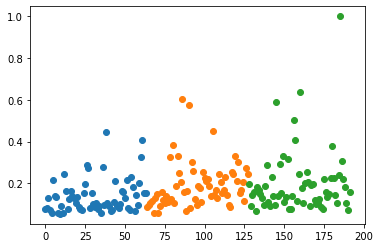

In [29]:
import matplotlib.pyplot as plt
plt.scatter(range(0,64),f_norm[0:64])
plt.scatter(range(64,64*2),f_norm[64:64*2])
plt.scatter(range(64*2,64*3),f_norm[64*2:64*3])